In [1]:
from itertools import chain
from random import random

import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm

from society.action import Action
from society.agent import Agent
from society.simulations.adaptive import AdaptiveSimulation
from society.agents.constant import AllC, AllD
from society.agents.qlearning import TabularQLearner, DoubleTabularQLearner
from society.agents.random import Random
from society.agents.tft import TitForTat
from society.visualisation.network import *

# plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["figure.figsize"] = (12, 5)

In [2]:
# def generate_population(communities, size):
#     population = communities * size

#     agents = [
#         TabularQLearner(lookback=1, epsilon=0.1, learning_rate=0.05)
#         for i in range(population)
#     ]

#     G = nx.connected_caveman_graph(communities, size)

#     weights_matrix = np.zeros((population, population))
#     for u, v, d in G.edges(data=True):
#         weights_matrix[u, v] = weights_matrix[v, u] = 1
#         try:
#             d["weight"] = weights_matrix[u, v]
#         except:
#             d["weight"] = 0

#     return agents, weights_matrix, G

In [3]:
def generate_population(communities, size):
    population = communities * size

    agents = [
        DoubleTabularQLearner(lookback=1, epsilon=0.1, learning_rate=0.05, discount_factor=0.98)
        for i in range(population)
    ]

    G = nx.connected_caveman_graph(communities, size)

    # G = nx.Graph()
    # G.add_weighted_edges_from([
    #     (0, i, 1) for i in range(1, population)
    # ])

    weights_matrix = np.zeros((population, population))
    for u, v, d in G.edges(data=True):
        weights_matrix[u, v] = weights_matrix[v, u] = 1
        try:
            d["weight"] = weights_matrix[u, v]
        except:
            d["weight"] = 0

    return agents, weights_matrix, G

In [4]:
# _, _, G = generate_population(2, 16)

# nx.draw(G, pos=nx.spring_layout(G), font_color="white", with_labels=True)

In [5]:
def compute_policies(agents):
    policies = [
        agent._q_table.argmax(axis=-1)
        if hasattr(agent, "_q_table") else None
        for agent in agents
    ]

    return [
        "".join(
            [
                ("C", "D")[policy[i]]
                for i in range(4)
                # for j in range(4)
                # for k in range(4)
            ]
        )
        if policy is not None else "OTHER"
        for policy in policies
    ]

def calculate_cooperativeness(history):
    count = history.count(Action.COOPERATE)

    return count / len(history)

In [6]:
PAYOFF_LABELS = ["(C, C)", "(C, D)", "(D, C)", "(D, D)"]
# PAYOFF_LABELS = ["R", "S", "T", "P"]

Run 1:   0%|          | 0/20000 [00:00<?, ?it/s]

BEST AGENT (55): 125929 (0.8474418393311524, DDDD)
WORST AGENT (145): 68924 (0.4505840071877808, CDDC)


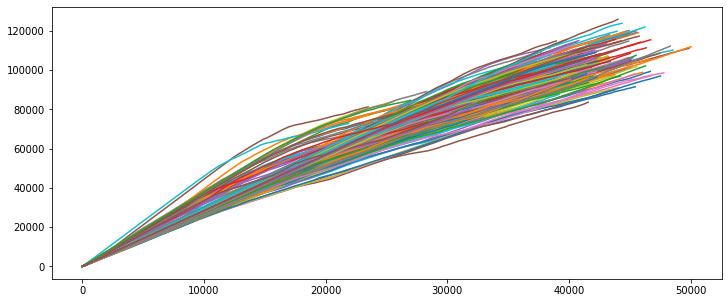

In [7]:
POPULATION = (32, 8)
ROUNDS = 20_000

run_rewards = []
run_cumulative_rewards = []
# run_action_histories = []
run_reward_histories = []
run_policies = []

for run in range(1):
    # Generate a new population
    agents, weights_matrix, G = generate_population(*POPULATION)

    # Run a number of rounds
    sim = AdaptiveSimulation(agents, weights_matrix)

    # Run the simulation
    sim.reset()
    for i in tqdm(range(ROUNDS), desc=f"Run {run + 1}"):
        sim.play_round(train=True)

    # Store results
    run_rewards.append(sim.rewards)
    # run_action_histories.append(sim.action_histories)
    run_reward_histories.append(sim.reward_histories)
    run_policies.append(compute_policies(agents))

    # Output statistics for the best and worst agents
    cumulative_rewards = [(i, sum(history)) for i, history in enumerate(sim.reward_histories)]
    cumulative_rewards.sort(key=lambda x: x[1], reverse=True)

    tqdm.write(
        f"BEST AGENT ({cumulative_rewards[0][0]}): {cumulative_rewards[0][1]} ({calculate_cooperativeness(list(chain(*sim.action_histories[cumulative_rewards[0][0]])))}, {run_policies[-1][cumulative_rewards[0][0]]})"
    )
    tqdm.write(
        f"WORST AGENT ({cumulative_rewards[-1][0]}): {cumulative_rewards[-1][1]} ({calculate_cooperativeness(list(chain(*sim.action_histories[cumulative_rewards[-1][0]])))}, {run_policies[-1][cumulative_rewards[-1][0]]})"
    )

    for rh in sim.reward_histories:
        plt.plot(np.cumsum(rh))
    
    plt.show()


In [8]:
# plot_matrix(sim.produce_weight_matrix(), digits=2, figsize=(60, 36))

In [9]:
# plot_matrix(sim.frequencies, digits=0, figsize=(60, 36))

In [10]:
sim.calculate_weights()

[array([0.39237939, 0.40143497, 0.39176955, 0.40444192, 0.13274736,
        0.31132135, 0.40955719]),
 array([0.37353482, 0.3803401 , 0.3716416 , 0.38147219, 0.13383595,
        0.31083092]),
 array([0.39237939, 0.37353482, 0.43661111, 0.46525108, 0.42756165,
        0.15657851, 0.36450732]),
 array([0.40143497, 0.3803401 , 0.43661111, 0.4462406 , 0.4371372 ,
        0.1610393 , 0.35615275]),
 array([0.39176955, 0.3716416 , 0.46525108, 0.4462406 , 0.44588261,
        0.15887873, 0.34828334]),
 array([0.40444192, 0.38147219, 0.42756165, 0.4371372 , 0.44588261,
        0.15417937, 0.36332781]),
 array([0.13274736, 0.13383595, 0.15657851, 0.1610393 , 0.15887873,
        0.15417937, 0.14101644]),
 array([0.31132135, 0.31083092, 0.36450732, 0.35615275, 0.34828334,
        0.36332781, 0.14101644, 0.2591428 ]),
 array([0.2591428 , 0.20267468, 0.20553259, 0.07949301, 0.1089989 ,
        0.07223115, 0.2110238 ]),
 array([0.21658403, 0.21486239, 0.06402027, 0.09806727, 0.06703929,
        0.2042

In [11]:
sim.action_histories[0][2]

[<Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.DEFECT: 1>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.DEFECT: 1>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>

In [12]:
cumulative_rewards[0][0]

55

In [13]:
if hasattr(agents[cumulative_rewards[0][0]], "_q_table"):
    print(agents[cumulative_rewards[0][0]]._q_table)

[[267.71030429 268.74398699]
 [267.94355826 270.38846824]
 [267.5321103  270.9521414 ]
 [268.37657364 272.93173451]]


In [14]:
agents[cumulative_rewards[4][0]].play_move([Action.COOPERATE, Action.COOPERATE], [Action.COOPERATE, Action.COOPERATE])

<Action.DEFECT: 1>

In [15]:
agents[1]._q_table

array([[230.85797252, 237.82777105],
       [224.37193376, 236.40734288],
       [229.12997157, 240.42597012],
       [230.9664869 , 240.63408587]])

In [16]:
# from datetime import datetime
# import pickle

# with open(f"results - {datetime.isoformat(datetime.now()).replace(':', '-')}.pickle", "wb") as f:
#     pickle.dump({
#         "rewards": run_rewards,
#         "cumulative_rewards": run_cumulative_rewards,
#         # "action_histories": run_action_histories,
#         "reward_histories": run_reward_histories,
#         "policies": run_policies,
#     }, f)


In [17]:
cumulative_reward_policy_ranks = {}
cumulative_reward_policies = {}

for policies, reward_histories in zip(run_policies, run_reward_histories):
    cumulative_rewards = [(i, sum(history)) for i, history in enumerate(reward_histories)]
    cumulative_rewards.sort(key=lambda x: x[1], reverse=True)

    for rank, (i, cumulative_reward) in enumerate(cumulative_rewards):
        policy = policies[i]

        if policy not in cumulative_reward_policy_ranks:
            cumulative_reward_policy_ranks[policy] = []
            cumulative_reward_policies[policy] = []

        cumulative_reward_policy_ranks[policy].append(rank + 1)
        cumulative_reward_policies[policy].append(cumulative_reward)

mean_cumulative_reward_policy_ranks = {policy: np.mean(ranks) for policy, ranks in cumulative_reward_policy_ranks.items()}
mean_cumulative_reward_policies = {policy: np.mean(rewards) for policy, rewards in cumulative_reward_policies.items()}

In [18]:
for policy in sorted(mean_cumulative_reward_policy_ranks, key=lambda x: mean_cumulative_reward_policy_ranks[x]):
    print(f"{mean_cumulative_reward_policy_ranks[policy]:<24} {policy}")

42.5                     DDCD
70.16666666666667        CCCD
101.4                    CCDD
107.73333333333333       DDDC
109.4                    CCCC
110.5                    DCCD
113.63636363636364       DDCC
117.0                    DCCC
119.0                    DCDD
119.01960784313725       DDDD
133.75                   DCDC
134.8709677419355        CDDD
139.88888888888889       CDCC
147.58823529411765       CDCD
163.0                    CDDC
204.0                    CCDC


In [19]:
for policy in sorted(mean_cumulative_reward_policies, key=lambda x: mean_cumulative_reward_policies[x], reverse=True):
    print(f"{mean_cumulative_reward_policies[policy]:<24} {policy}")

113301.375               DDCD
108184.0                 CCCD
104659.46666666666       DDDC
103900.9                 CCDD
103466.25                DCDD
103055.0                 DDDD
103025.0                 DCCD
103001.6                 CCCC
102914.75                DCDC
102508.5                 DCCC
101478.7258064516        CDDD
101176.18181818182       DDCC
98758.0                  CDCC
97931.82352941176        CDCD
95537.67647058824        CDDC
85525.2                  CCDC


In [20]:
compute_policies([agents[cumulative_rewards[0][0]]])[0]

'DDDD'

In [21]:
if hasattr(agents[cumulative_rewards[0][0]], "_q_table"):
    print(agents[cumulative_rewards[0][0]]._q_table)

[[267.71030429 268.74398699]
 [267.94355826 270.38846824]
 [267.5321103  270.9521414 ]
 [268.37657364 272.93173451]]


In [22]:
from itertools import product

P = compute_policies([agents[cumulative_rewards[0][0]]])[0]

for m, p in zip(product(PAYOFF_LABELS, PAYOFF_LABELS), P):
    print(m, "=>", p)

('(C, C)', '(C, C)') => D
('(C, C)', '(C, D)') => D
('(C, C)', '(D, C)') => D
('(C, C)', '(D, D)') => D
